<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/220111_camera_openCV_cat_mustache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# 라이브러리 import
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math


In [7]:
# 디렉토리 생성

!mkdir -p ~/aiffel/camera_sticker/models
!mkdir -p ~/aiffel/camera_sticker/images
!mkdir -p ~/data

# 이렇게 할 경우 colab의 root아래에 aiffel과 기타 폴더들이 생성된다.

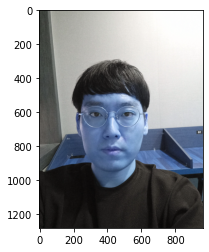

In [31]:
# 준비한 이미지 읽기

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지를 읽어서
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관
img_bgr_ori = img_bgr.copy() # 고양이 수염 붙이기 위한 작업
plt.imshow(img_bgr) 
plt.show()

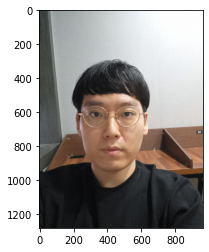

In [10]:
# BGR을 RGB로 변환 -> 색깔이 정상적으로 돌아옴
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [11]:
# 이미지 다루기 정리

# cv2.imread(fileName, flag) 함수를 이용하여 이미지 파일 읽기

# cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어 들인다. 투명한 부분은 무시되며, default값이다.
# cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들인다. 중간 단계로 많이 사용.
# cv2.IMREAD_UNCHANGED : 이미지 파일을 alpha channel까지 포함하여 읽어 들임.

# cv2.imshow(title, image)함수는 이미지를 사이즈에 맞게 보여준다.
# cv2.waitKey()는 keyboard입력을 대기하는 함수로 0이면 key 입력까지 무한 대기이며, 특정 시간동안 대기하려면 milisecond값을 넣어주면 된다.
# cv2.destryAllWindows()는 화면에 나타난 윈도우를 종료

# 위의 3가지는 보통 같이 사용한다.


# cv2.imwrite(fileName, image)는 변환된 이미지나 동영상의 특정 프레기음 저장한다.


In [12]:
# Q1. cv2.imread('img.png', 0) 에서 0 은 무슨 의미일까요?

# 문서에 따르면 이미지 읽기의 flag는 다음 3가지가 있습니다. 순서대로 1, 0, -1의 값을 갖습니다.

# cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
# cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
# cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.
# cv2.imread('img.png', 0)이라고 호출했다면 이미지를 Grayscale로 읽어 들이겠다는 뜻입니다. 실제로 이미지 읽기 flag를 바꿔가면서 이미지가 어떻게 출력되는지 확인해 보세요.

In [13]:
# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

In [14]:
# detector_hog를 이용해서 얼굴의 bounding box를 추출한다.

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) 

# dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor()를 이용해서 opencv의 bgr이미지를 rgv로 변환
# detector_hog의 두 번째 파라미터는 이미지 피라미드의 수이다.
# 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다.
# 이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능하다.

# 파이썬으로 만드는 OpenCV 프로젝트 p.244 ~ 246
# 이렇게 하는 이유는 영상을 분석할 때 먼저 작은 이미지로 빠르게 훑어보고 다음 단계 크기의 영상으로 분석하는 식으로 정확도를 높이는 것이 효율적이기도 하고 영상의 크기에 따라 분석하는 내용이 다를수 있기 때문!


# upsampling이란.
# 간단하게 데이터의 크기를 키우는 것이다. 일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것을 down sampling 이라고 하는데, down sampling의 반대개념이 upsampling인 것이다.


rectangles[[(194, 502) (656, 965)]]


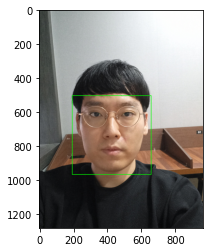

In [15]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)
for dlib_rect in dlib_rects:
  l = dlib_rect.left()
  t = dlib_rect.top()
  r = dlib_rect.right()
  b = dlib_rect.bottom()
  cv2.rectangle(img_show, (l,t), (r,b),(0,255,0),2,lineType=cv2.LINE_AA)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [16]:
# 3-4. 얼굴 랜드마크 face landmark

# 스티커를 섬세하게 적용하기 위해서는 이목귀비의 위치를 아는 것이 중요하다.
# 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다.

# facelandmark는 detection의 결과물인 bounding box로 잘라낸(crop)얼굴 이미지를 이용한다.


In [17]:
# Dlib landmark localization

# 잘라진 얼굴 이미지에서 68개의 이목구비 위치를 찾는다.

# Dlib은 ibug 300-W 데이터셋으로 학습한 pretained model을 제공.
# 공개되어 있는 weight file을 다운로드하고 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
!cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2


--2022-01-16 09:17:24--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  56.4MB/s    in 1.1s    

2022-01-16 09:17:25 (56.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [18]:
# 다운로드 받은 landmark 불러오기
model_path = os.getenv("HOME")+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor는 RGB 이미지와 dlib.rectangle을 이력받아 dlib.full_object_detection를 반환


In [19]:
# landmark 찾기

list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아 낸다.

for dlib_rect in dlib_rects:
  points = landmark_predictor(img_rgb, dlib_rect)
  # face landmark 좌표를 저장해둔다.
  list_points = list(map(lambda p: (p.x, p.y), points.parts()))
  list_landmarks.append(list_points)

# landmark 개수 확인
print(len(list_landmarks[0]))


# points는 dlib.full_object_detection의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다.
# 조금 더 직관적인 (x,y) 형태로 접근할 수 있도록 변환해 주었다.
# 따라서 list_points 는 tuple(x, y) 68개로 이루어진 리스트가 된다.

# 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장.


68


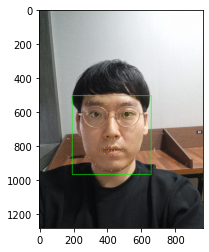

In [20]:
# landmark 찾기

for landmark in list_landmarks:
  for point in landmark:
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [21]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))


(420, 718)
(x,y) : (420,718)
(w,h) : (463,463)


(463, 463, 3)


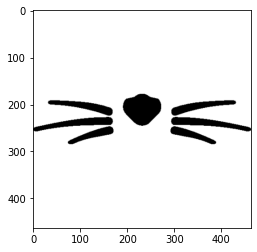

In [22]:
# 고양이 수염 스티커 이미지 Read

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [23]:
# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (189,487)


In [24]:
# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(463, 463, 3)
(x,y) : (189,487)


In [25]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식이다.

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

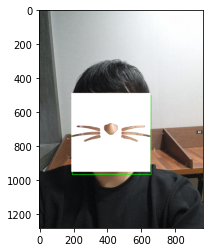

In [26]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

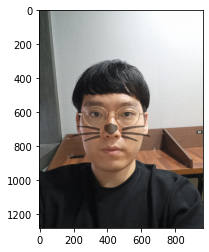

In [32]:
# 출력시에 고양이 이미지에 불투명도를 줄 필요가 있다.

sticker_area = img_bgr_ori[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 참고한 url : https://deep-learning-study.tistory.com/115
# 파이썬으로 만드는 openCV 프로젝트 p.137

In [33]:
# 고양이 수염을 그리긴 하였으나, 문제점이 있는데, 항상 정면샷으로 찍으리란 법은 없다.

# 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
# 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
# 실행 속도가 중요할까요?
# 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

# 생각 해봐야 할 문제들이다.

In [34]:
 # 최근 핫한 신인 걸그룹 케플러 김다연의 기울어진 사진으로 다시 해보자!

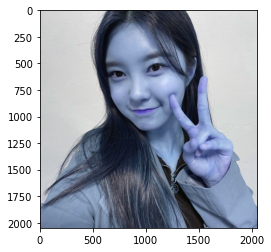

In [35]:
 # 준비한 이미지 읽기

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.png'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지를 읽어서
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관
img_bgr_ori = img_bgr.copy() # 고양이 수염 붙이기 위한 작업
plt.imshow(img_bgr) 
plt.show()



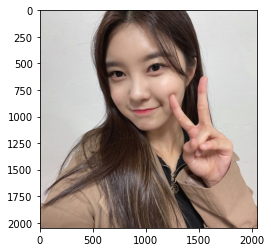

In [36]:
# BGR을 RGB로 변환 -> 색깔이 정상적으로 돌아옴
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [38]:
# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

In [39]:
# detector_hog를 이용해서 얼굴의 bounding box를 추출한다.

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) 


rectangles[[(514, 337) (1313, 1136)]]


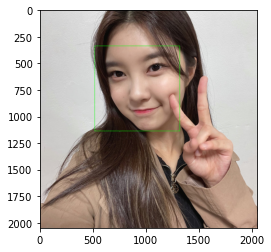

In [40]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)
for dlib_rect in dlib_rects:
  l = dlib_rect.left()
  t = dlib_rect.top()
  r = dlib_rect.right()
  b = dlib_rect.bottom()
  cv2.rectangle(img_show, (l,t), (r,b),(0,255,0),2,lineType=cv2.LINE_AA)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [41]:
# 다운로드 받은 landmark 불러오기
model_path = os.getenv("HOME")+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [42]:
# landmark 찾기

list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아 낸다.

for dlib_rect in dlib_rects:
  points = landmark_predictor(img_rgb, dlib_rect)
  # face landmark 좌표를 저장해둔다.
  list_points = list(map(lambda p: (p.x, p.y), points.parts()))
  list_landmarks.append(list_points)

# landmark 개수 확인
print(len(list_landmarks[0]))

68


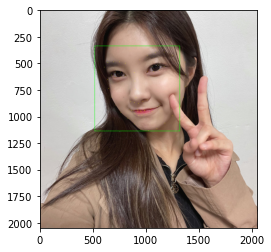

In [43]:
# landmark 찾기

for landmark in list_landmarks:
  for point in landmark:
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [44]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(901, 824)
(x,y) : (901,824)
(w,h) : (800,800)


(800, 800, 3)


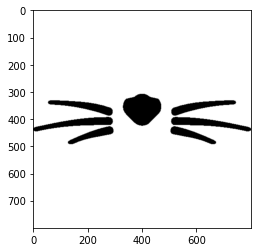

In [45]:
# 고양이 수염 스티커 이미지 Read

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [46]:
# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (501,424)


In [47]:
# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(800, 800, 3)
(x,y) : (501,424)


In [48]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식이다.

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

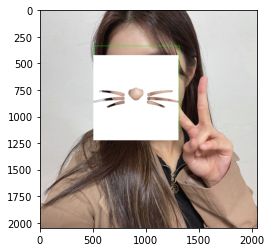

In [49]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

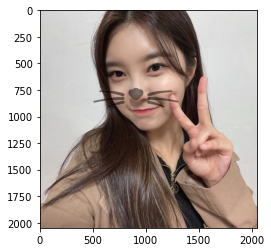

In [51]:
# 출력시에 고양이 이미지에 불투명도를 줄 필요가 있다.

sticker_area = img_bgr_ori[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [52]:
# 다음과 같이 고개 기울어져 있어서 고양이 수염 자체가 피팅이 되지 않았다.

# 책들과 문헌을 찾아본 결과 다음과 같이 해결할 수 있다고 결론을 내리게 되었다.
# 1. 수학적으로 Vector를 계산하여 회전 변환을 할것!
# 2. 원근법 변환 (Perspective Transformation)을 이용하여 접근

# 현재 주어진 시간과 능력치로 1번으로 시도하기에는 너무나도 리스크가 커 2번으로 접근하였다.


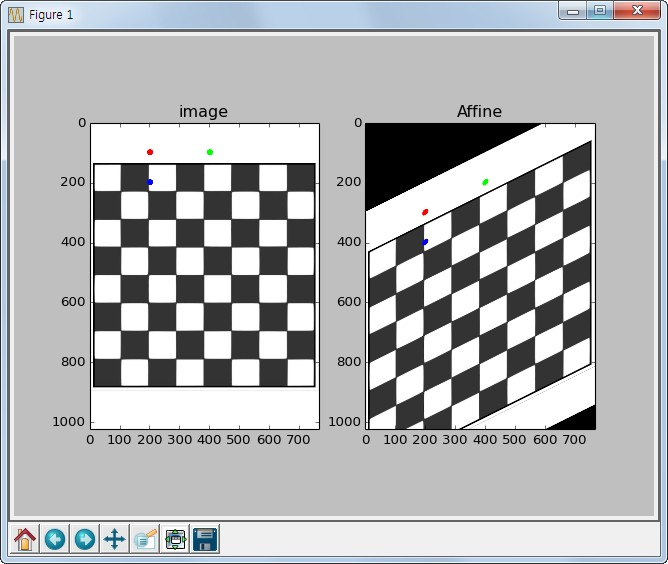

In [53]:
# refrence url : https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html
# https://deep-learning-study.tistory.com/200

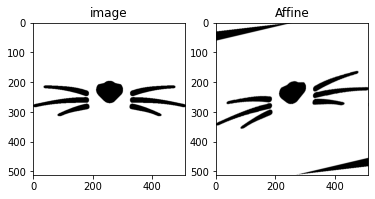

In [111]:
# 위의 사진에서 보이는 것처럼 Affine한 형태는 기울기가 심하지면, 약간의 변경을 거치면, 적절하게 바꿀수 있을 것 같았다.

img = cv2.imread(os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_mustache.png')
rows, cols, ch = img.shape
# 좌표 자체는 Affie 변환을 위해서 3개의 Match가 되는점이 있으면 변환 행렬을 구할 수 있다.
pts1 = np.float32([[180,300],[350,210],[180,210]])
pts2 = np.float32([[180,310],[350,200],[180,220]])

# pts1의 좌표에 표시. Affine 변환 후 이동 점 확인.
# cv2.circle(img, (180,300), 10, (255,0,0,0),-1) 
# cv2.circle(img, (350,210), 10, (0,255,0,0),-1)
# cv2.circle(img, (180,210), 10, (0,0,255,0),-1)


M = cv2.getAffineTransform(pts1, pts2)

dst = cv2.warpAffine(img, M, (cols,rows))

# 탈락된 외곽 픽셀을 투명하게 보정
dst2 = cv2.warpAffine(dst, M, (cols,rows), None, \
                     cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT)
# 외곽의 검은색의 절반만 투명하게 된다. -> 고쳐지지 않은 문제점
plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst2),plt.title('Affine')
plt.show()

In [ ]:
# 다음과 같이 메뉴얼로 계산하여 고양이 수염자체를 기울였다. 

In [112]:
#우선 저장한다.
cv2.imwrite(os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_mustache_modified2.png', dst)

True

(800, 800, 3)


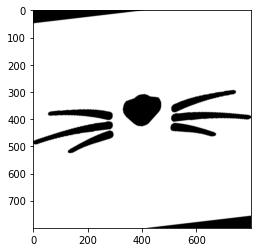

In [113]:
# 고양이 수염 스티커 이미지 Read (위의 과정 재탕! 파일만 바꿔서!)

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_mustache_modified2.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [114]:
# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (501,424)


In [115]:
# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(800, 800, 3)
(x,y) : (501,424)


In [116]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식이다.

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

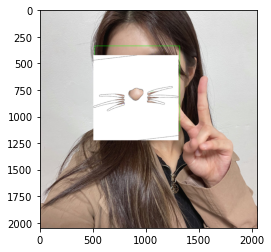

In [117]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

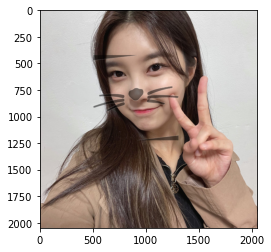

In [118]:
# 출력시에 고양이 이미지에 불투명도를 줄 필요가 있다.

sticker_area = img_bgr_ori[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [119]:
# 위에서 생각해봐야할 문제점이었다.

# 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
# --> Affine 변환 기능을 통해서 변환하였다.
# 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
# --> 멀리서 촬영하면, 전체 비율도 줄어들고, 옆으로 누워서 촬영하면, 눈코잎의 거리 비율자체를 새롭게 생각해야 된다.
# 실행 속도가 중요할까요?
# --> 실행 속도가 중요하다. 특히 앱에서는 실시간 동영상으로 움직여지므로 고양이 수염이 코와 affine 변환에서 처럼 3개의 좌표를 기준으로 실시간으로 움직여야 한다.
# 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
# --> 정확도가 중요하다. 괜히 이상한곳에 수염이 붙으면 안되니까..


In [ ]:
# 총평 및 해결해야 할 문제

# 우선적으로는 사진을 Affine 변환 하였을때 탈락된 외곽픽셀을 투명하게 하려고 시도 했으나, 되지 않아서 김다연양의 목과 이마에 검은 이미지가 묻어 버렸다.
# 급선무적으로 해결해야 할 문제라서 검색과 책을 통해 검색하였으나, 답이 나오지 않았다.

# 탈락된 외곽 픽셀을 투명하게 보정
# dst2 = cv2.warpAffine(dst, M, (cols,rows), None, \
#                      cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT)

# 영어로도 검색을 해보았으나, border_transparent가 먹히지 않는건 찾을수 없었다.
# 분명히 방법이 있을텐데, 더 검색을 해보아야 할 것 같다.

# 그리고 지금 이 과정은 사람의 눈으로 메뉴얼적인 과정으로 수정을 했으나, 자동으로 인지하여 Affine 변환이 되는 것을 만드는 과정이 따라 주어야 할 것 같다.
# Open CV를 잘하기 위해서 한가지 느낀것은 기본적인 선형대수를 필히 공부 해야겠다는 것이었다.

